__Ny modell. Nu delar vi upp datat på omgångarna, inte slumpmässigt. Totalt 222 omgångar. Bygger modell på 175 omgångar, validerar på de övriga. Imputerar för missing innan vi kör modellen, tar bort detta steg från data pipelinen. Vi läser även in VNUM som är rankingen efter spelade hästar för att jämföra med den framtagna modellen__

__I denna modell plockar vi bort GRUPP eftersom denna verkar driva hela modellen__

In [162]:
# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [163]:
from sklearn.model_selection import GridSearchCV 

In [164]:
# Necessary Sklearn objects used in the analysis
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

In [165]:
# Where to save the figures
PROJECT_ROOT_DIR = os.getcwd()
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR)

In [166]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [167]:
df1 = pd.read_excel('DataV75TillUffe_2019-02-01_2.xlsx')

In [168]:
# Skapar en unik nyckel på lopp: Gör om Datum och lopp till en sträng

df1['cdate'] = df1.Datum.astype('object')
df1['cLopp'] = df1.Lopp.astype('object')

In [169]:
df1['Key'] = df1['cdate'].astype(str) + df1['cLopp'].astype(str)

In [170]:
len(df1)

17994

In [171]:
df1.Key.drop_duplicates().count()

1554

__Skapar en målvariabel - vinnare__

In [172]:
df1['Y'] = np.where(df1['Plac'].isin([1]), 1,0)

__Plockar bort de variabler som inte ska med__

In [173]:
df1 = df1. \
drop(['Utdelning','Arstid','Distans','Startsatt','Lopp','Plac','Hast','cdate','cLopp','V_ODDS','S_R', \
      'V75PROC','TK_R'], axis = 1). \
copy().set_index(['Key'])

In [174]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17994 entries, 2016-05-21 00:00:001 to 2019-01-05 00:00:007
Data columns (total 28 columns):
Datum          17994 non-null datetime64[ns]
GRUPP          17994 non-null int64
VLP            17994 non-null float64
VNUM           17994 non-null int64
SVLP           17994 non-null float64
VSVLP          17994 non-null float64
VPN_SUM        17994 non-null float64
VPN_SUM_ORD    17994 non-null int64
VPK_SUM        17994 non-null float64
VPK_SUM_ORD    17994 non-null int64
VLPB           17994 non-null float64
SVLPB          17994 non-null float64
VSVLPB         17994 non-null float64
E_P            17994 non-null float64
E_P_Num        17994 non-null int64
E_N            17994 non-null float64
E_R            17994 non-null float64
E_U            17994 non-null float64
G_R            16243 non-null float64
A_R            15310 non-null float64
T_R            16317 non-null float64
SP_R           4730 non-null float64
ToR            15201 non-null 

In [175]:
# Gör om hast och grupp till objekt
df1['GRUPP'] = df1.GRUPP.astype('object')

__Delar upp i numeriska samt charachter attribut. Det är dessa som går in i modellen__

In [176]:
num_attribs = [] 
cat_attribs = [] 

for var, typ in zip(df1.columns[:-1], df1.dtypes[:-1]): 
    if typ == 'object': 
        cat_attribs.append(var) 
    elif (typ != 'datetime64[ns]') & (var != 'VNUM'): 
        num_attribs.append(var)

In [177]:
cat_attribs

['GRUPP']

In [178]:
num_attribs

['VLP',
 'SVLP',
 'VSVLP',
 'VPN_SUM',
 'VPN_SUM_ORD',
 'VPK_SUM',
 'VPK_SUM_ORD',
 'VLPB',
 'SVLPB',
 'VSVLPB',
 'E_P',
 'E_P_Num',
 'E_N',
 'E_R',
 'E_U',
 'G_R',
 'A_R',
 'T_R',
 'SP_R',
 'ToR',
 'P_R',
 'Ex_R',
 'R_R',
 'Ts_R']

In [17]:
len(num_attribs)

24

__Imputerar medianvärdet på alla numeriska variabler__

In [88]:
for var in num_attribs:
    median = df1[var].median()
    df1[var] = df1[var].fillna(median)

__Nu plockar vi ut 52 v75 omgångar för att använda dem som test__

In [89]:
v75 = df1.Datum.drop_duplicates().to_frame()

In [90]:
v75['is_test']=np.random.uniform(0,1,len(v75))<=0.2

test, basedf = v75[v75['is_test']==True], v75[v75['is_test']==False]

In [91]:
len(test)

47

__Nu bygger vi upp en pipeline__

In [179]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
# Denna klass måste vi göra för att särskilja numeriska variabler mot character variabler
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [180]:
# Egen klass för att sätta dummyvariabler

class SetDummyVar(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        tempdf = pd.get_dummies(X[self.attribute_names], columns = self.attribute_names)
        return tempdf.values

In [181]:
# Pipeline för numeriska variabler
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median"))
    ])

cat_pipeline = Pipeline([
        ('dummy_cat', SetDummyVar(cat_attribs)),
    ])

In [182]:
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

### In order to avoid overfitting data is split into training data and validation data. 75% träningsdata och 25% valideringsdata

In [96]:
train = df1[df1.Datum.isin(basedf.Datum.tolist())]

In [97]:
validate = df1[df1.Datum.isin(test.Datum.tolist())]

### Nu skapar vi arrayer som ska användas av modellen - använder den skapade Pipelineobjektet som gör alla nödvändiga dataransformationer 

In [98]:
# Träningssdata
# Alla förklaringsvaribler i en multidimensionell array där kategrisvaribler har gjorts om till
# dummyvariabler
features_train = full_pipeline.fit_transform(train)
## En array som håller det vi vill predikter
label_train = train["Y"].copy()

In [99]:
# Valideringsdata
# Alla förklaringsvaribler i en multidimensionell array där kategrisvaribler har gjorts om till
# dummyvariabler
features_validate = full_pipeline.fit_transform(validate)
## En array som håller det vi vill predikter
label_validate = validate["Y"].copy()

# Train the model on the training data and then evaluate on the validation data

- predicts: A twodimensional array that contains posterrior probabbility for a donation behaviour, one for non-donation and one for donation
- fpr : False positive rate, number of false positive for a specific threshold value
- tpr : True positive rate, number of true positive for a specific threshold value
- threshold: Sorted threshold (descending) values for the likelihod to donate
- roc_auc: Receiver operating characteristics. A value close to 1 indicates a strong model. A value close to 0.5 means that the model is rather poor

In [100]:
# Bygger random forrest och analyserar roc_auc
# Instansierar modellen
rf = RandomForestClassifier(n_estimators = 1000, max_depth=5)

# Tränar modellen

rf.fit(features_train,label_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [101]:
# Predikterar med modellen med valideringsdata

predict = rf.predict_proba(features_validate)

fpr, tpr, threshold = roc_curve(label_validate,predict[:,1])

roc_auc = auc(fpr,tpr)

In [207]:
fpr_ser = pd.Series(fpr)
tpr_ser = pd.Series(tpr)
threshold_ser = pd.Series(threshold)

In [33]:
# Median värde för den sannolikhet som genereras på varje enskild observation
prob = pd.Series(predict[:,1])
prob.median()

0.056242175425278575

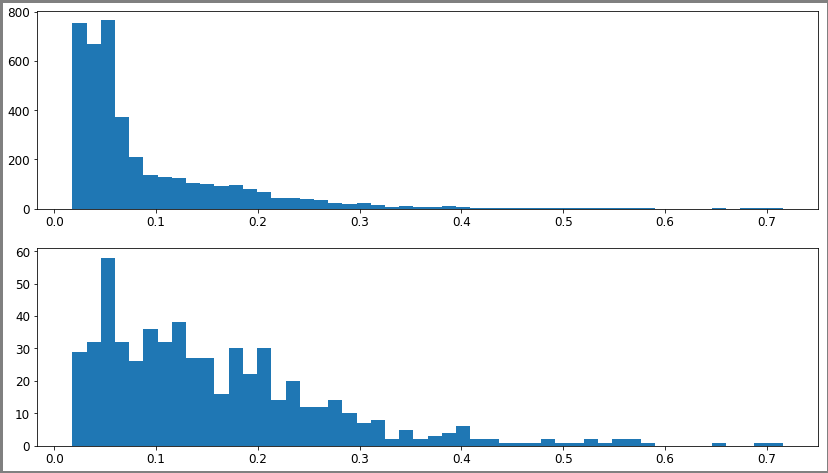

In [34]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8), linewidth=5, edgecolor='.5')


ax1.hist(prob, bins = 50)
ax2.hist(threshold, bins = 50)

plt.show()

__Varför ger threshold och prob olika medianvärden?__



__It traces out two types of error as we vary the threshold value for the posterior probability of charity. The actual thresholds are not shown. The true positive rate is the sensitivity: the fraction of givers that are correctly identified, using a given threshold value. The false positive rate is 1-specificity: the fraction of non-givers that we classify incorrectly as givers, using that same threshold value. The ideal ROC curve hugs the top left corner, indicating a high true positive rate and a low false positive rate. The dotted line represents the “no information” classifier.__ 

Saving figure ROC


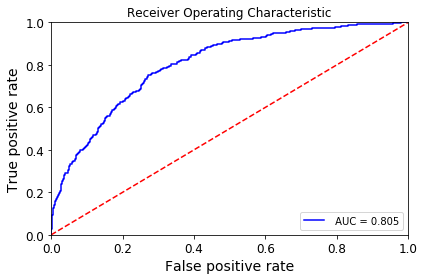

In [102]:
# Graf

plt.title('Receiver Operating Characteristic') 
plt.plot( fpr, tpr, 'b', label =' AUC = %0.3f' % roc_auc) 
plt.legend( loc ='lower right') 
plt.plot([ 0, 1], [0, 1], 'r--') 
plt.xlim([ 0.0, 1.0]) 
plt.ylim([ 0.0, 1.0]) 
plt.ylabel('True positive rate') 
plt.xlabel('False positive rate') 
save_fig('ROC')
plt.show()

In [36]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(label_validate, prob)

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [38]:
 
y_truth = label_validate
confusion_matrix(label_validate, y_truth)

array([[3671,    0],
       [   0,  350]])

In [39]:
prob.median()

0.056242175425278575

In [40]:
# Vi väljer medianvärdet som cut off 
y_pred = np.where( prob > prob.median(),1,0)
 
confusion_matrix(label_validate, y_pred)

array([[1964, 1707],
       [  47,  303]])

In [41]:
# Precision - Av de vi predikterar som vinnare, hur bra är vi
precision_score(label_validate, y_pred)

0.15074626865671642

In [42]:
# True positive rate = Den totala andelen av sanna postiva vid en given cut of
recall_score(label_validate, y_pred)
 

0.8657142857142858

In [43]:
label_validate_ser = pd.Series(label_validate.tolist())
prob_ser = pd.Series(prob)

In [44]:
df_valid = pd.concat([label_validate_ser, prob_ser], axis = 1).rename(columns = {0:'Y',1 :'Prob'}). \
sort_values('Prob')

__Delar in i deciler på den framräknade scoren__

In [45]:
data = df_valid.Prob.values
quartiles = pd.qcut(data, 10)
pd.value_counts(quartiles)

(0.0167, 0.0259]    403
(0.196, 0.716]      402
(0.137, 0.196]      402
(0.0911, 0.137]     402
(0.0658, 0.0911]    402
(0.0562, 0.0658]    402
(0.0492, 0.0562]    402
(0.0406, 0.0492]    402
(0.0328, 0.0406]    402
(0.0259, 0.0328]    402
dtype: int64

In [46]:
df_valid.Y.sum()

350

In [47]:
grouped = df_valid.Y.groupby(quartiles)

In [48]:
grouped.count()

(0.0167, 0.0259]    403
(0.0259, 0.0328]    402
(0.0328, 0.0406]    402
(0.0406, 0.0492]    402
(0.0492, 0.0562]    402
(0.0562, 0.0658]    402
(0.0658, 0.0911]    402
(0.0911, 0.137]     402
(0.137, 0.196]      402
(0.196, 0.716]      402
Name: Y, dtype: int64

__Beräknar den procentuella andelen vinnare i respektice decil__

In [49]:
resp = round((grouped.sum() / grouped.count() * 100))
resp

(0.0167, 0.0259]     2.0
(0.0259, 0.0328]     1.0
(0.0328, 0.0406]     2.0
(0.0406, 0.0492]     3.0
(0.0492, 0.0562]     3.0
(0.0562, 0.0658]     5.0
(0.0658, 0.0911]     7.0
(0.0911, 0.137]     15.0
(0.137, 0.196]      14.0
(0.196, 0.716]      34.0
Name: Y, dtype: float64

Saving figure Probdist


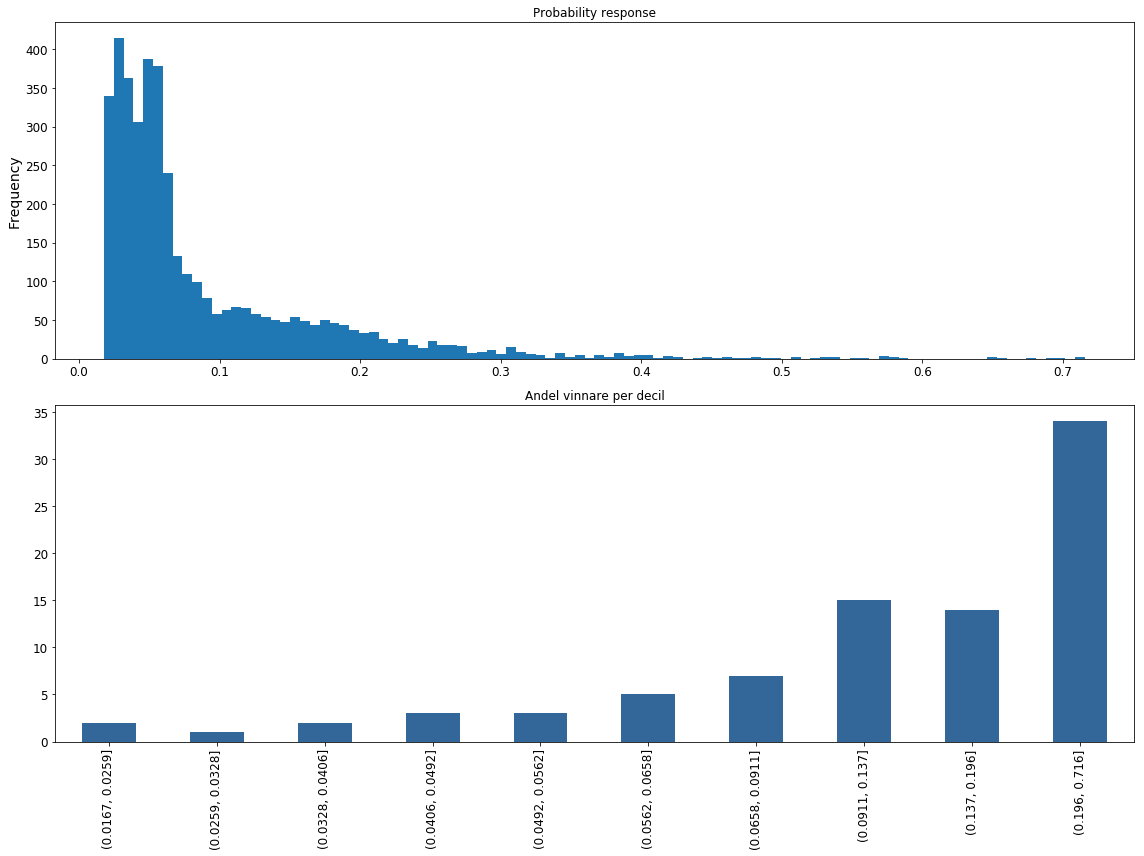

In [50]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))


df_valid.Prob.plot(kind = 'hist', bins = 100, title = 'Probability response', ax = ax1)


resp.plot(kind = 'bar', color=(0.2, 0.4, 0.6, 1),title = 'Andel vinnare per decil', ax = ax2)

save_fig('Probdist')

In [51]:
y_pred = np.where(prob >=0.137,1,0)
 
confusion_matrix(label_validate, y_pred)

array([[3059,  612],
       [ 159,  191]])

In [52]:
 
precision_score(label_validate, y_pred)

0.23785803237858033

In [53]:
# True positive rate = Den totala andelen av sanna postiva vid en given cut of
recall_score(label_validate, y_pred)
 

0.5457142857142857

In [54]:
y_pred = np.where(prob >=0.0911,1,0)
 
confusion_matrix(label_validate, y_pred)

array([[2715,  956],
       [  99,  251]])

In [55]:
precision_score(label_validate, y_pred)

0.207953603976802

In [56]:
# True positive rate = Den totala andelen av sanna postiva vid en given cut of
recall_score(label_validate, y_pred)

0.7171428571428572

In [57]:
predict_cutoff = pd.DataFrame({'Prob0':predict[:,0],'Prob1':predict[:,1]}).sort_values('Prob1', ascending = False).iloc[24]['Prob1']

__Nu itererar vi över alla testloppen. Plockar de 24 högsta scorade hästarna__

In [58]:
cm_list = []
d_list = validate.Datum.drop_duplicates().tolist()
for date in d_list:
    df_test1 = validate[validate.Datum == date].drop('Datum', axis = 1)
    features_test = full_pipeline.fit_transform(df_test1)
    label_test = df_test1["Y"].copy()
    predict_test = rf.predict_proba(features_test)
    
    predict_cutoff = pd.DataFrame({'Prob0':predict_test[:,0],'Prob1':predict_test[:,1]}).sort_values('Prob1', ascending = False).iloc[24]['Prob1']
    
    y_pred_test = np.where( predict_test[:,1] > predict_cutoff,1,0)
    print(confusion_matrix(label_test, y_pred_test),date)
    # Stoppar in i lista
    cm_list.append(confusion_matrix(label_test, y_pred_test)[1][1])

[[56 19]
 [ 2  5]] 2016-05-21 00:00:00
[[59 18]
 [ 1  6]] 2016-07-16 00:00:00
[[51 18]
 [ 1  6]] 2016-07-26 00:00:00
[[55 20]
 [ 3  4]] 2016-08-06 00:00:00
[[54 18]
 [ 1  6]] 2016-08-27 00:00:00
[[57 18]
 [ 1  6]] 2016-10-22 00:00:00
[[60 18]
 [ 1  6]] 2016-11-12 00:00:00
[[58 19]
 [ 2  5]] 2016-11-27 00:00:00
[[64 19]
 [ 2  5]] 2017-02-26 00:00:00
[[58 18]
 [ 1  6]] 2017-03-11 00:00:00
[[52 19]
 [ 2  5]] 2017-04-08 00:00:00
[[52 19]
 [ 2  5]] 2017-04-14 00:00:00
[[54 21]
 [ 4  3]] 2017-04-29 00:00:00
[[51 22]
 [ 5  2]] 2017-05-14 00:00:00
[[59 19]
 [ 2  5]] 2017-05-20 00:00:00
[[49 19]
 [ 2  5]] 2017-07-09 00:00:00
[[52 21]
 [ 4  3]] 2017-07-15 00:00:00
[[51 21]
 [ 4  3]] 2017-08-05 00:00:00
[[45 20]
 [ 3  4]] 2017-08-12 00:00:00
[[51 18]
 [ 1  6]] 2017-09-23 00:00:00
[[50 18]
 [ 1  6]] 2017-09-30 00:00:00
[[60 19]
 [ 2  5]] 2017-10-01 00:00:00
[[57 19]
 [ 2  5]] 2017-10-07 00:00:00
[[57 18]
 [ 1  6]] 2017-10-29 00:00:00
[[60 20]
 [ 3  4]] 2017-11-12 00:00:00
[[52 19]
 [ 2  5]] 2017-1

In [59]:
sum_tot = 0
for val in cm_list:
    sum_tot = sum_tot + val

avg = sum_tot / len(cm_list)
avg

5.04

__På score__

In [60]:
cm_list = []
d_list = validate.Datum.drop_duplicates().tolist()
for date in d_list:
    df_test1 = validate[validate.Datum == date].drop('Datum', axis = 1)
    features_test = full_pipeline.fit_transform(df_test1)
    label_test = df_test1["Y"].copy()
    predict_test = rf.predict_proba(features_test)
    
    y_pred_test = np.where( predict_test[:,1] > 0.0911,1,0)
    print(confusion_matrix(label_test, y_pred_test),date)
    # Stoppar in i lista
    cm_list.append(confusion_matrix(label_test, y_pred_test)[1][1])
    

[[55 20]
 [ 2  5]] 2016-05-21 00:00:00
[[58 19]
 [ 1  6]] 2016-07-16 00:00:00
[[48 21]
 [ 1  6]] 2016-07-26 00:00:00
[[54 21]
 [ 3  4]] 2016-08-06 00:00:00
[[53 19]
 [ 1  6]] 2016-08-27 00:00:00
[[58 17]
 [ 1  6]] 2016-10-22 00:00:00
[[62 16]
 [ 1  6]] 2016-11-12 00:00:00
[[58 19]
 [ 1  6]] 2016-11-27 00:00:00
[[63 20]
 [ 2  5]] 2017-02-26 00:00:00
[[56 20]
 [ 1  6]] 2017-03-11 00:00:00
[[50 21]
 [ 2  5]] 2017-04-08 00:00:00
[[53 18]
 [ 3  4]] 2017-04-14 00:00:00
[[74  1]
 [ 6  1]] 2017-04-29 00:00:00
[[72  1]
 [ 7  0]] 2017-05-14 00:00:00
[[78  0]
 [ 6  1]] 2017-05-20 00:00:00
[[67  1]
 [ 5  2]] 2017-07-09 00:00:00
[[51 22]
 [ 3  4]] 2017-07-15 00:00:00
[[50 22]
 [ 3  4]] 2017-08-05 00:00:00
[[41 24]
 [ 3  4]] 2017-08-12 00:00:00
[[49 20]
 [ 1  6]] 2017-09-23 00:00:00
[[48 20]
 [ 1  6]] 2017-09-30 00:00:00
[[60 19]
 [ 2  5]] 2017-10-01 00:00:00
[[57 19]
 [ 3  4]] 2017-10-07 00:00:00
[[54 21]
 [ 0  7]] 2017-10-29 00:00:00
[[58 22]
 [ 3  4]] 2017-11-12 00:00:00
[[54 17]
 [ 2  5]] 2017-1

In [61]:
sum_tot = 0
for val in cm_list:
    sum_tot = sum_tot + val

avg = sum_tot / len(cm_list)
avg

5.02

In [64]:
cm_list = []
d_list = validate.Datum.drop_duplicates().tolist()
for date in d_list:
    df_test1 = validate[validate.Datum == date].drop('Datum', axis = 1)
    df_test1['Pred'] = np.where(df_test1.VNUM.isin([1,2,3,4]),1,0)
    df_test1['Facit'] =  np.where((df_test1.Pred == 1) & (df_test1.Y == 1) ,1,0)
    cm_list.append(df_test1.Facit.sum())

In [65]:
sum_tot = 0
for val in cm_list:
    sum_tot = sum_tot + val

avg = sum_tot / len(cm_list)
avg

5.56

In [122]:
RandomForestClassifier?

__Nedan försöker vi optimera modellen med Gridsearch samt använder sig av hela datasetet med Cross validation__

In [185]:
param_grid = { 
    'n_estimators': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

In [186]:
# Allt data
# Alla förklaringsvaribler i en multidimensionell array där kategrisvaribler har gjorts om till
# dummyvariabler
features = full_pipeline.fit_transform(df1)
## En array som håller det vi vill predikter
labels = df1["Y"].copy()

In [187]:
rf_all = RandomForestClassifier()

In [188]:
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(rf_all, param_grid, cv=5, scoring = 'roc_auc' , return_train_score=True)
grid_search.fit(features, labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30], 'max_features': ['auto', 'sqrt', 'log2'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [189]:
grid_search.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 30}

__Nu stoppar vi in denna uppsättning i modellen och utvärderar__

In [121]:
RandomForestClassifier?

In [190]:
rf_opt = RandomForestClassifier(n_estimators = 30, max_features = 'log2', criterion = 'entropy' )

In [191]:
scores_opt = cross_val_score(rf_opt , features, labels , scoring = "roc_auc", cv = 5 ) 

In [192]:
scores_opt 

array([0.78518984, 0.75488525, 0.76261823, 0.78956607, 0.76315154])

In [193]:
scores_opt.mean()

0.7710821852684175

In [199]:
rf_opt.fit(features,labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [200]:
from sklearn.externals import joblib

# Pipelineobjekt
joblib.dump(full_pipeline, 'Pipeline_v4.pkl')

# Modellobjekt
joblib.dump(rf_opt, 'Travmodel_v4.pkl')

['Travmodel_v4.pkl']

__Deafault inställningen__

In [194]:
rf = RandomForestClassifier()

In [195]:
scores = cross_val_score(rf, features, labels , scoring = "roc_auc", cv = 5 ) 

In [196]:
scores

array([0.78309218, 0.70202422, 0.73213615, 0.7577677 , 0.69805734])

In [197]:
scores.mean()

0.7346155161968818